## Import libs

In [1]:
import tensorflow as tf
from pathlib import Path
from util.dataset import Dataset as madras_Dataset
from util import read_data as rd
from tensorflow.keras import layers
from zhang.models import FairLogisticRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from util import metrics
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries

In [2]:
batch_size = 64
epochs = 1000
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

## Load data

In [3]:
data_name = 'adult'

data_info = rd.return_data_info(data_name)
npzfile = rd.return_npz(data_name)

data = madras_Dataset(npzfile=npzfile, name=data_name, a0_name=data_info['a0_name'], a1_name=data_info['a1_name'], 
                use_a=data_info['use_a'], seed=data_info['seed'], batch_size=batch_size)

data_shapes = list(data.get_shapes())
#print(data_shapes)

xdim = data_shapes[0][1]
ydim = data_shapes[1][1]
adim = data_shapes[2][1]
zdim = 8

In [4]:
train_data = Dataset.from_tensor_slices((data.x_train, data.y_train, data.a_train))
train_data = train_data.batch(batch_size)
train_data

<BatchDataset shapes: ((None, 113), (None, 1), (None, 1)), types: (tf.float64, tf.float32, tf.float32)>

In [5]:
valid_data = Dataset.from_tensor_slices((data.x_valid, data.y_valid, data.a_valid))
valid_data = valid_data.batch(batch_size)

## Train loop

In [6]:
import math

def projection(v, x):
    if v==0:
        return 0
    else:
        return 1 #idk what to return yet

def train(model, X, Y, A, optimizer, alpha=1, learning_rate=0.001):
    clas_vars = [model.clas.W] #+ model.b + model.c
    adv_vars = [model.adv.U, model.b, model.adv.c]
    #adv_vars = [model.adv.U, model.b, model.c]
    variables = [model.clas.W, model.b]
    #variables = [model.clas.W, model.adv.U]
    #variables = [model.clas.W]

    with tf.GradientTape(persistent=True) as clas_tape, tf.GradientTape() as adv_tape:
        
        #adv_tape.watch(adv_vars)
        #clas_tape.watch(variables)

        model(X, Y, A) #to compute the foward
        adv_loss = model.adv_loss #current adversarial loss
        clas_loss = model.clas_loss #current classifier loss
        model_loss = model.model_loss

        print(adv_loss)
        print(clas_loss)

    if math.isnan(adv_loss) or math.isnan(clas_loss):
        return True
    #print(model.adv.U)
    #print(model.b)
    #print(model.adv.c)
    dULa = clas_tape.gradient(adv_loss, adv_vars) #adv_grads
    #print('dULa ', dULa)
    optimizer.apply_gradients(zip(dULa, adv_vars))

    dWLp = clas_tape.gradient(clas_loss, variables) #regular grads for classifier
    #print('dWLp ', dWLp)
    dWLa = clas_tape.gradient(adv_loss, variables) #grads for W with the adversarial loss
    #print('dWLa ', dWLa)
    proj_dWLa_dWLp = projection(dWLa, dWLp) #prevents the classifier from moving in a direction that helps the adversary decrease its loss
    #print('proj ', proj_dWLa_dWLp)
    #print('alpha ', alpha)
    #max_adv_loss = tf.multiply(alpha,dWLa) #terms that attemps to increase adv loss'''
    max_adv_loss = [] #terms that attemps to increase adv loss
    for i in range(len(dWLa)):
        max_adv_loss.append(tf.multiply(alpha, dWLa[i]))
    #print('max ', max_adv_loss)
    
    proj_minus_max_adv_loss = [] 
    for i in range(len(max_adv_loss)):
        proj_minus_max_adv_loss.append(tf.multiply(proj_dWLa_dWLp, max_adv_loss[i]))
    #print('max ', max_adv_loss)
    #clas_grads = tf.subtract(dWLp, tf.subtract(proj_dWLa_dWLp, max_adv_loss))
    #clas_grads = tf.subtract(dWLp, dWLa)
    clas_grads = []
    for i in range(len(dWLa)):
        clas_grads.append(tf.subtract(dWLp[i],  proj_minus_max_adv_loss[i]))
    #print('clas grads', clas_grads)
    optimizer.apply_gradients(zip(clas_grads, variables))

    return False

In [7]:
from math import sqrt
def train_loop(model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc")

    losses = {'clas':[], 'adv':[]}
    accs = {'clas':[], 'adv':[]}

    dps = []
    dis = []
    deopps = []

    batch = 1
    
    for epoch in range(epochs):
        clas_losses = []
        adv_losses = []
        clas_accs = []
        adv_accs = []

        dp = []
        di = []
        deopp = []

        alpha=sqrt(epoch+1)
        lr=1/(epoch+1)
        
        for X, Y, A in train_dataset:
            print('batch ', batch)
            batch+=1
            
            r = train(model, X, Y, A, optmizer, alpha, lr)
            if r:
                break

            clas_losses.append(model.clas_loss)
            adv_losses.append(model.adv_loss)
            
            clas_accs.append(metrics.accuracy(Y, tf.math.round(model.Y_hat)))
            adv_accs.append(metrics.accuracy(A, tf.math.round(model.A_hat)))
            dp.append(metrics.DP(tf.math.round(model.Y_hat).numpy(), A))
            di.append(metrics.DI(Y.numpy(), tf.math.round(model.Y_hat).numpy(), A.numpy()))
            deopp.append(metrics.DI_soft(Y.numpy(), tf.math.round(model.Y_hat).numpy(), A.numpy()))

        losses['clas'].append(clas_losses)
        losses['adv'].append(adv_losses)
        
        accs['clas'].append(metrics.accuracy(Y, model.Y_hat))
        accs['adv'].append(metrics.accuracy(A, model.A_hat))

        dps.append(tf.math.reduce_mean(dp))
        dis.append(tf.math.reduce_mean(di))
        deopps.append(tf.math.reduce_mean(deopp))
    
        print("> {} | {} | {} | {} | {}".format(
            epoch+1, 
            tf.math.reduce_mean(losses['clas'][-1]),
            tf.math.reduce_mean(losses['adv'][-1]),
            tf.math.reduce_mean(accs['clas'][-1]),
            tf.math.reduce_mean(accs['adv'][-1])))

    return losses, accs, dps, dis, deopps

## Validation

In [8]:
def validation(model, valid_data):
    losses = {'clas':[], 'dec':[], 'adv':[], 'model':[]}
    accs = {'clas':[], 'dec':[], 'adv':[]}
    
    for X, Y, A in valid_data:
        
        model(X, Y, A)
        
        losses['clas'].append(model.clas_loss)
        losses['adv'].append(model.adv_loss)
            
        accs['clas'].append(metrics.accuracy(Y, tf.math.round(model.Y_hat)))
        accs['adv'].append(metrics.accuracy(A, tf.math.round(model.A_hat)))
    
    print("> Class Loss | Adv Loss | Class Acc | Adv Acc")
    print("> {} | {} | {} | {}".format(
            tf.math.reduce_mean(losses['clas']),
            tf.math.reduce_mean(losses['adv']),
            tf.math.reduce_mean(accs['clas']),
            tf.math.reduce_mean(accs['adv'])))

    return losses, accs

## Testing if models are being trained

### For DP

### For EqOdds

In [9]:
fairdef='EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)

In [10]:
model.adv.U

<tf.Variable 'U:0' shape=(1, 3) dtype=float32, numpy=array([[0.22346526, 0.07876457, 0.86875653]], dtype=float32)>

In [11]:
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
batch  1
tf.Tensor(
[[ 9.9999750e-01]
 [ 9.9987984e-01]
 [ 9.9998975e-01]
 [ 9.9999619e-01]
 [ 9.9998021e-01]
 [ 9.9968886e-01]
 [ 9.9942374e-01]
 [ 9.4075060e-01]
 [ 1.0000000e+00]
 [ 9.9966717e-01]
 [ 9.9988437e-01]
 [ 9.9985802e-01]
 [ 9.9980277e-01]
 [ 9.9999177e-01]
 [ 9.9960643e-01]
 [ 9.9230415e-01]
 [ 9.9680281e-01]
 [-9.9999999e-09]
 [ 9.9971610e-01]
 [ 9.9993908e-01]
 [ 9.9973315e-01]
 [ 9.9998903e-01]
 [ 9.9982738e-01]
 [ 9.9996173e-01]
 [ 9.9999988e-01]
 [ 9.9713266e-01]
 [ 9.9969375e-01]
 [ 9.9999917e-01]
 [ 9.9986219e-01]
 [ 9.9997485e-01]
 [ 9.9972457e-01]
 [ 9.9996305e-01]
 [ 9.9989414e-01]
 [ 9.9991429e-01]
 [ 9.9821681e-01]
 [ 9.9981147e-01]
 [ 9.9991035e-01]
 [ 8.8092726e-01]
 [ 9.9988759e-01]
 [ 9.9985600e-01]
 [ 9.9999785e-01]
 [ 9.9987316e-01]
 [ 9.9998522e-01]
 [ 9.3986332e-01]
 [ 9.9999404e-01]
 [ 9.9973315e-01]
 [ 9.9978477e-01]
 [ 9.9999309e-01]
 [ 9.9959117e-01]
 [ 9.9944979e-01]
 [ 9.9979514e-01]
 [ 9.997

In [12]:
print(pare)

NameError: name 'pare' is not defined

In [13]:
ret=validation(model, valid_data)

> Class Loss | Adv Loss | Class Acc | Adv Acc
> 0.6914596557617188 | 0.7940637469291687 | 0.769780585106383 | 0.6321476063829787


### For EqOpp

## Models

In [22]:
#For EODD
laftr_losses, laftr_accs, laftr_dps, laftr_dis, laftr_deopps, unfair_losses, unfair_accs, unfair_dps, unfair_dis, unfair_deopps = madras_valid(10, 'EODD', fair_coeff_list)

NameError: name 'madras_valid' is not defined

In [27]:
unfair_accs4di = unfair_accs

unfair_dps4di = unfair_dps
laftr4di = sorted(zip(unfair_dps4di, unfair_accs4di))
sorted_unfair_dps4di, sorted_unfair_accs_dps4di = zip(*laftr4di)

unfair_dis4di = unfair_dis
laftr4di = sorted(zip(unfair_dis4di, unfair_accs4di))
sorted_unfair_dis4di, sorted_unfair_accs_dis4di = zip(*laftr4di)

unfair_deopps4di = unfair_deopps
laftr4di = sorted(zip(unfair_deopps4di, unfair_accs4di))
sorted_unfair_deopps4di, sorted_unfair_accs_eopps4di = zip(*laftr4di)

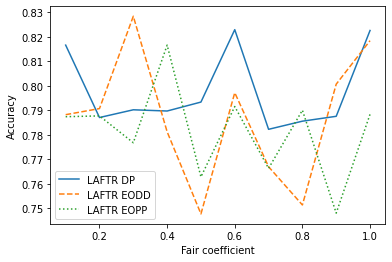

In [30]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_accs4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_accs4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_accs4deopp, ':', label = "LAFTR EOPP")
plt.xlabel('Fair coefficient')
plt.legend()
plt.show()

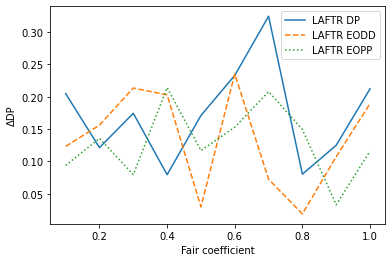

In [31]:
plt.plot()
plt.ylabel('\u0394DP')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_dps4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_dps4deopp, ':', label = "LAFTR EOPP")

plt.xlabel('Fair coefficient')
plt.legend()
plt.show()

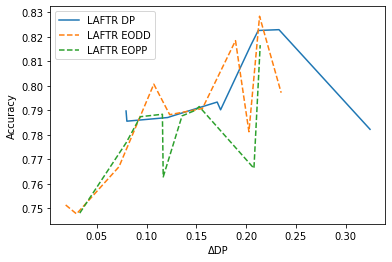

In [32]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
plt.plot(sorted_unfair_dps4dp, sorted_unfair_accs_dps4dp, label = "LAFTR DP")
plt.plot(sorted_unfair_dps4di, sorted_unfair_accs_dps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_dps4deopp, sorted_unfair_accs_dps4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

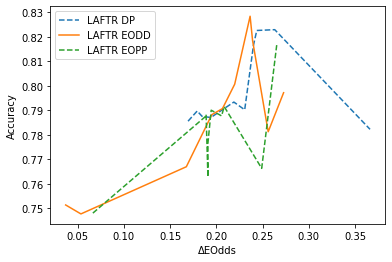

In [33]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
plt.plot(sorted_unfair_dis4dp, sorted_unfair_accs_dis4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_dis4di, sorted_unfair_accs_dis4di, label = "LAFTR EODD")
plt.plot(sorted_unfair_dis4deopp, sorted_unfair_accs_dis4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394EOdds')
plt.legend()
plt.show()

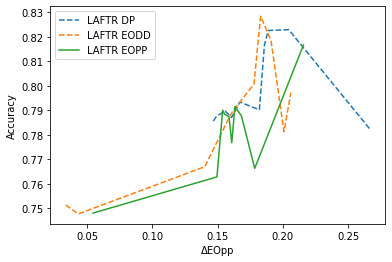

In [34]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
plt.plot(sorted_unfair_deopps4dp, sorted_unfair_accs_eopps4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_deopps4di, sorted_unfair_accs_eopps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_deopps4deopp, sorted_unfair_accs_eopps4deopp, label = "LAFTR EOPP")

plt.xlabel('\u0394EOpp')
plt.legend()
plt.show()